In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re
import sys
import os
import datetime
import pandas
import time
import torch

import typing
import gymnasium# as gym
# import gym
import sb3_contrib
import stable_baselines3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.logger import Logger
from stable_baselines3.common.logger import HumanOutputFormat

In [5]:
font = {"family": "serif",
        "weight": "normal",
        "size": 15}

matplotlib.rc("font", **font)
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams['figure.dpi'] = 75

def makeNiceAxes(ax, xlab=None, ylab=None):
    ax.tick_params(axis='both', reset=False, which='both', length=5, width=2)
    ax.tick_params(axis='y', direction='out', which="both")
    ax.tick_params(axis='x', direction='out', which="both")
    for spine in ['top', 'right','bottom','left']:
        ax.spines[spine].set_linewidth(2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    
def niceFig(xlab=None, ylab=None, figsize=None, nrows=1, ncols=1):
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    if (nrows == 1) and (ncols == 1):
        makeNiceAxes(ax, xlab, ylab)
    else:
        for axx in ax:
            try:
                makeNiceAxes(axx, xlab, ylab)
            except AttributeError:
                for axxx in axx:
                    makeNiceAxes(axxx, xlab, ylab)
    return fig, ax

def addColourBar(fig, cs, cbarLabel, pos=[0.85, .25, 0.03, 0.5], orientation="vertical"):
    position = fig.add_axes(pos)
    cbar = fig.colorbar(cs, cax=position, orientation=orientation)
    cbar.set_label(cbarLabel)
    return cbar

# DDR env

## Angle error function

In [6]:
def angleError(psi_d, psi):
    """
    Function used for computing signed heading error that wraps around pi properly.

    Parameters
    ----------
    psi_d : float
        Target heading in radians <0, 2pi).
    psi : float
        Current heading in radians <0, 2pi).

    Returns
    -------
    diff : float
        Signed difference in radians <-pi, pi).

    """
    a = (psi_d - psi) % (2.*np.pi)
    b = (psi - psi_d) % (2.*np.pi)
    diff = a if a < b else -b
    return diff

## Define the env

In [7]:
class DDREnv(gymnasium.Env):

    def __init__(self, max_episode_steps=300):
        self.max_episode_steps = max_episode_steps
        
        # Physical properties
        self.L = 0.2 # Wheelbase
        self.R = 0.05 # Wheel radius

        # Time step size.
        self.dt = 0.02
        
        # State variables and goal location. Modified by reset and step routines.
        self.stateData = None
        self.x_g = None
        self.d_old = None

        # Obs variables are: vector relative to the target (2 floats)
        self.observation_space = gymnasium.spaces.Box(-1., 1., shape=(2,), dtype=np.float64)

        # Translated to heading demand.
        self.action_space = gymnasium.spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float64)
    
    def _get_obs(self):
        pos = np.array([self.stateData["x"], self.stateData["y"]])
        vecToWaypoint = self.x_g - np.array([self.stateData["x"], self.stateData["y"]])
        dToWaypoint = np.sqrt(np.sum(vecToWaypoint**2.))
        return vecToWaypoint/dToWaypoint
    
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self.x_g - np.array([self.stateData["x"], self.stateData["y"]])),
            "old_distance": self.d_old,
        }
    
    def reset(self, seed: typing.Optional[int] = None, options: typing.Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the location of the agent and targer at random
        # TODO
        # rv = self.np_random.float(-1, 1, size=5, dtype=np.float32)
        rv = (np.random.rand(3)-0.5)*2.
        self.stateData = {"t": 0., "x": rv[0]*self.L, "y": rv[1]*self.L, "psi": rv[2]*self.L,
                          "psi_d": 0., "omega_r": 0., "omega_l": 0.}
        while True:
            self.x_g = (np.random.rand(2)-0.5)*2. * 3.*self.L
            if self._get_info()["distance"] > self.L*2.:
                self.d_old = self._get_info()["distance"]
                break

        observation = self._get_obs()
        info = self._get_info()
        
        self.iStep = 0

        return observation, info

    def step(self, action):
        # Prepare a new state.
        state = {v: 0. for v in self.stateData}
        
        # Convert action vector to heading.
        state["psi_d"] = action[0]*np.pi
        # For bypassing the actions.
        # obs = self._get_obs()
        # state["psi_d"] = np.arctan2(obs[1], obs[0])

        # Constant desired speed.
        uD = 0.2

        # PID control for the turning rate.
        K_p = 0.5
        K_i = 0.02
        K_d = 0.02
        maxRange = (-0.5, 0.5)
        e = angleError(state["psi_d"], self.stateData["psi"])
        e = np.arctan2(np.sin(e), np.cos(e))
        # TODO
        omega_d = e*K_p

        # Set control values.
        # NOTE: inverted here to match yx projection with x +ve North!!!
        state["omega_r"] = (2.*uD - omega_d/self.L) / (2.*self.R)
        state["omega_l"] = (2.*uD + omega_d/self.L) / (2.*self.R)

        # Velocities in the robot's reference frame.
        u = self.R * (state["omega_r"] + state["omega_l"])/2.
        # NOTE: inverted here for +ve omega with increasing heading
        omega = self.R/self.L * (state["omega_r"] - state["omega_l"]) * -1

        # Apply a coordinate transformation to get displacement rates in the global coordinates.
        vel = np.array([u, 0., omega])
        coordTransform = np.array([
            [np.cos(self.stateData["psi"]), -np.sin(self.stateData["psi"]), 0.],
            [np.sin(self.stateData["psi"]), np.cos(self.stateData["psi"]), 0.],
            [0., 0., 1.],
        ])
        vel = np.dot(coordTransform, vel)

        # Update position and time.
        state["t"] = self.stateData["t"] + self.dt
        state["x"] = self.stateData["x"] + vel[0]*self.dt
        state["y"] = self.stateData["y"] + vel[1]*self.dt
        state["psi"] = self.stateData["psi"] + vel[2]*self.dt
        
        # Store new state.
        self.stateData = state

        # Get the new observation and info.
        observation = self._get_obs()
        info = self._get_info()
        info["TimeLimit.truncated"] = False
        
        self.iStep += 1
        terminated = False
        truncated = False
        if info["distance"] < self.L*0.1:
            reward = 100
            terminated = True
        elif info["distance"] < info["old_distance"]:
            reward = 0.1
        elif self.iStep >= self.max_episode_steps:
            terminated = True
            truncated = True
            info["TimeLimit.truncated"] = True
            reward = 0
        else:
            reward = 0
        
        # Update current distance.
        self.d_old = info["distance"]
        
        return observation, reward, terminated, truncated, info

In [8]:
gymnasium.register(
    id="gymnasium_env/DDR-v0",
    entry_point=DDREnv,
)

# Example training

In [30]:
figDir = "D:/Reports/MARIN_report_2024_RLinCFD/Figures"

## Prepare agent and env instances

In [9]:
def make_env(env_class, rank, seed=0, env_kwargs={}):
    """
    Utility function for multiprocessed env.
    """

    def _init():
        env = env_class(**env_kwargs)
        # use a seed for reproducibility
        # Important: use a different seed for each environment
        # otherwise they would generate the same experiences
        env.reset(seed=seed+rank)
        return env

    set_random_seed(seed)
    return _init

In [10]:
env_class = DDREnv

env_kwargs = {"max_episode_steps": 1000}

agent_kwargs = {
    'learning_rate': 1e-2,
    'gamma': 0.98,
    'verbose': 0,
    'buffer_size': 25_000,
    'batch_size': 32,
    'train_freq': (1, "step"),
    "gradient_steps": 1,
}

policy_kwargs = {
    "activation_fn": torch.nn.GELU,
    "net_arch": dict(
        pi=[32, 32, 32],
        qf=[32, 32, 32],
    )
}

# nTrainingSteps = 50_000
# n_procs = 2

nTrainingSteps = 5_000
n_procs = 1

saveFile = "envTest7"

In [11]:
env_eval = env_class(**env_kwargs)

# Wrap in a monitor.
env_eval = Monitor(env_eval, os.path.join("D:/_temp", saveFile))

# Create callback that evaluates agent for N episodes every X training environment steps.
# When using multiple training environments, agent will be evaluated every
# eval_freq calls to train_env.step(), thus it will be evaluated every
# (eval_freq * n_envs) training steps. See EvalCallback doc for more information.
eval_callback = EvalCallback(env_eval, best_model_save_path=os.path.join("D:/_temp"+saveFile),
                              log_path="D:/_temp", eval_freq=500,
                              n_eval_episodes=5, deterministic=True,
                              render=False, verbose=-1)

if n_procs == 1:
    # if there is only one process, there is no need to use multiprocessing
    env_train = DummyVecEnv([lambda: env_class(**env_kwargs)])
else:
    env_train = SubprocVecEnv(
        [make_env(env_class, i) for i in range(n_procs)],
        start_method="spawn",
    )

In [12]:
agent = sb3_contrib.TQC(
    "MlpPolicy", env_train, policy_kwargs=policy_kwargs, **agent_kwargs)

## Train

In [13]:
env_train.reset()

# Train
time_start = datetime.datetime.now()
agent.learn(total_timesteps=nTrainingSteps, callback=eval_callback, progress_bar=True)
training_time = (datetime.datetime.now() - time_start).total_seconds()
print("Learning took {:.0f} seconds".format(training_time))

# Important: when using subprocesses, don't forget to close them
# otherwise, you may have memory issues when running a lot of experiments
env_train.close()

Output()

Learning took 299 seconds


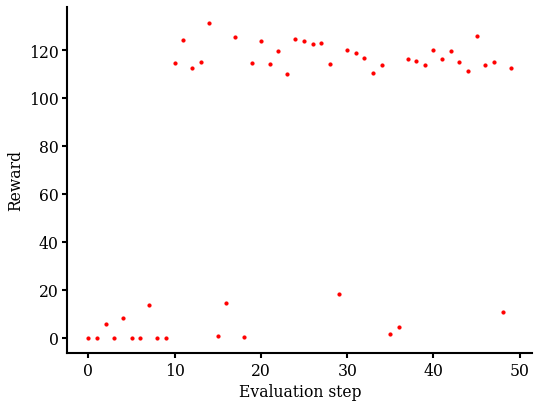

In [14]:
trainingStats = pandas.read_csv(os.path.join("D:/_temp", saveFile+".monitor.csv"), skiprows=1)

fig, ax = niceFig("Evaluation step", "Reward")
ax.plot(trainingStats.index, trainingStats["r"], "r.")

## Evaluate

In [15]:
def concatEpisodeData(state, obs, actions, reward):
    ed = state
    ed["reward"] = reward
    for i in range(len(obs)):
    # for v in obs:
        ed[f"o{i:d}"] = obs[i]
    for i in range(len(actions)):
        ed[f"a{i:d}"] = actions[i]
    return ed

In [16]:
class DummyDdrAgent(object):
    def predict(self, obs, deterministic=True):
        try:
            return np.array([np.arctan2(obs[1], obs[0]) / np.pi]), None
        except AttributeError:
            # During training, this gets given an obs and info as a tuple
            obs = obs[0]
            return np.array([np.arctan2(obs[1], obs[0]) / np.pi]), None

In [17]:
def evaluationEpisode(env_eval, agent, nStepsMax=500, seed=None, fixedConditions=False):
    obs, info = env_eval.reset(seed=seed)
    if fixedConditions:
        env_eval.unwrapped.x_g = np.array([-0.35, -0.2])
        env_eval.unwrapped.stateData["x"] = 0.
        env_eval.unwrapped.stateData["y"] = 0.
        env_eval.unwrapped.stateData["psi"] = 0.
    episodeData = [concatEpisodeData(env_eval.unwrapped.stateData, obs,
                                     np.zeros(len(env_eval.action_space.sample())), 0.)]

    for i in range(nStepsMax):
        action, _states = agent.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info  = env_eval.step(action)
        episodeData.append(concatEpisodeData(env_eval.unwrapped.stateData, obs, action, reward))
        if terminated:
            break

    episodeData = pandas.DataFrame(episodeData)
    
    return episodeData

In [18]:
episodeData = {
    "RL": evaluationEpisode(env_eval, agent, seed=123, fixedConditions=True),
    "Deterministic": evaluationEpisode(env_eval, DummyDdrAgent(), seed=123, fixedConditions=True),
}

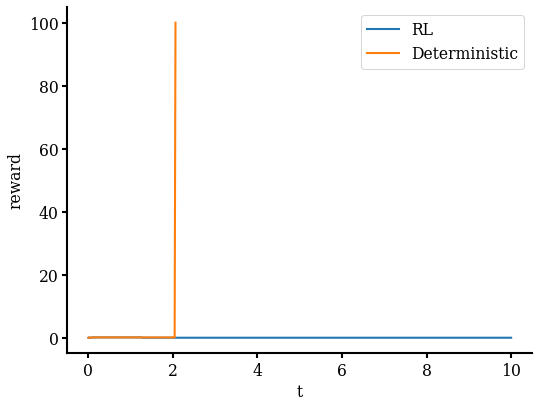

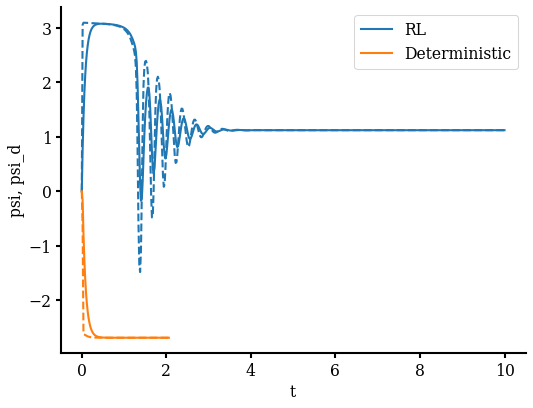

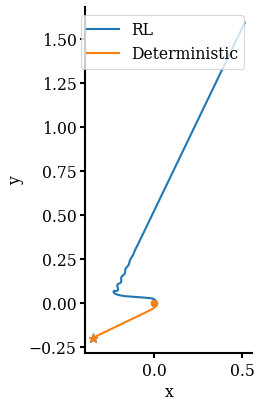

In [19]:
fig, ax = niceFig("t", "reward")
for variant in episodeData:
    ax.plot(episodeData[variant]["t"], episodeData[variant]["reward"], "-", lw=2, label=variant)
ax.legend()

fig, ax = niceFig("t", "psi, psi_d")
for variant in episodeData:
    ln = ax.plot(episodeData[variant]["t"], episodeData[variant]["psi"], "-", lw=2, label=variant)[0]
    ax.plot(episodeData[variant]["t"], episodeData[variant]["psi_d"], "--", lw=2, c=ln.get_color())
ax.legend()

fig, ax = niceFig("x", "y")
ax.set_aspect("equal")
for variant in episodeData:
    ln = ax.plot(episodeData[variant]["x"], episodeData[variant]["y"], "-", lw=2, label=variant)[0]
    ax.plot(episodeData[variant].loc[0, "x"], episodeData[variant].loc[0, "y"], "o", c=ln.get_color())
    ax.plot(env_eval.unwrapped.x_g[0], env_eval.unwrapped.x_g[1], "*", c=ln.get_color(), ms=9)
ax.legend()

# Custom buffer

Idea - fix no. time steps that we want to shove into the buffer at every synchronisation step. Run the computations in parallel and collect data in a sub-buffer on the head process the way it has been done now. Once there are enough data points in the sub-buffer, merge it with the main buffer and call the update step.

## Data collection and buffer

In [20]:
# Step 1 - collect observations using the current iteration of the agent.

def collect_simulated_data(agent, env, n_steps=1000):
    """
    Simulate environment interactions to generate training data.
    """
    obs_list, actions_list, rewards_list, next_obs_list, dones_list, infos_list = \
        [], [], [], [], [], []
    retVals = env.reset()
    # DummyVecEnv does something else (again).
    try:
        obs = retVals[0]
    except ValueError:
        obs = retVals
    
    for _ in range(n_steps):
        # Get action and step.
        # TODO for dummy vec env this doesn't effing work
        action, _ = agent.predict(obs, deterministic=False)
        # print(action)
        retVals = env.step(action)
        
        # DummyVecEnv and regular env may or may not contain the truncated variable...
        try:
            next_obs, reward, done, truncated, info = retVals
        except ValueError:
            next_obs, reward, done, info = retVals
            info = [info]
        
        # Store this transition.
        # print(obs)
        obs_list.append(obs)
        actions_list.append(action)
        rewards_list.append(reward)
        next_obs_list.append(next_obs)
        dones_list.append(done)
        infos_list.append(info)
        
        # Clean slate of the env or carry on.
        if not done:
            obs = next_obs
        else:
            retVals = env.reset()
            try:
                obs = retVals[0]
            except ValueError:
                obs = retVals
    
    # Reset at the end for env reuse outside of the scope.
    env.reset()

    # Convert lists to numpy arrays
    return (
        np.array(obs_list), 
        np.array(actions_list), 
        np.array(rewards_list), 
        np.array(next_obs_list), 
        np.array(dones_list),
        np.array(infos_list)
    )


# env_train = DummyVecEnv([lambda: env_class(**env_kwargs)])
# obs, actions, rewards, next_obs, dones, infos = \
#     collect_simulated_data(agent, env_train, n_steps=10)

# agent = DummyDdrAgent()
# # agent = sb3_contrib.TQC("MlpPolicy", env_train, policy_kwargs=policy_kwargs, **agent_kwargs)

# env_eval = env_class(**env_kwargs)
# env_eval.reset()
# obs, actions, rewards, next_obs, dones, infos = \
#     collect_simulated_data(agent, env_eval, n_steps=10)

In [21]:
# Step 2 - create a custom buffer and push the data into it.

class AsyncReplayBuffer(ReplayBuffer):
    def __init__(
        self,
        buffer_size: int,
        observation_space: gymnasium.spaces.Space,
        action_space: gymnasium.spaces.Space,
        device: typing.Union[torch.device, str] = "auto",
        n_envs: int = 1,
        optimize_memory_usage: bool = False,
        handle_timeout_termination: bool = True,
    ):
        super().__init__(buffer_size, observation_space, action_space, device, n_envs=n_envs,
                         optimize_memory_usage=False, handle_timeout_termination=True)

    def add_batch(self, observations, actions, rewards, next_observations, dones, infos):
        """
        Add a batch of transitions to the buffer.
        observations, actions, rewards, next_observations, dones are arrays of shape (batch_size, ...)
        
        Note that the super().add interface is as follows:
        
            def add(
                self,
                obs: np.ndarray,
                next_obs: np.ndarray,
                action: np.ndarray,
                reward: np.ndarray,
                done: np.ndarray,
                infos: List[Dict[str, Any]],
            ) -> None:
        """
        for i in range(len(observations)):
            self.add(
                obs=observations[i],
                next_obs=next_observations[i],
                action=actions[i],
                reward=rewards[i],
                done=dones[i],
                infos=[infos[i]]
            )


# agent = DummyDdrAgent()
# # agent = sb3_contrib.TQC("MlpPolicy", env_train, policy_kwargs=policy_kwargs, **agent_kwargs)
# env_eval = env_class(**env_kwargs)
# env_eval.reset()
# obs, actions, rewards, next_obs, dones, infos = \
#     collect_simulated_data(agent, env_eval, n_steps=10)

# buffer = AsyncReplayBuffer(10_000, env_train.observation_space,
#                            env_train.action_space, "auto", n_envs=1)

# buffer.add_batch(obs, actions, rewards, next_obs, dones, infos)

## Custom training loop

In [22]:
# Step 3 - Custom training loop that uses the custom buffer and batched data collection.

# agent_kwargs = {
#     'learning_rate': 1e-3,
#     'gamma': 0.98,
#     'verbose': 0,
#     'buffer_size': 25_000,
#     'batch_size': 32,
#     'train_freq': (1, "step"),
#     "gradient_steps": 1,
# }

# policy_kwargs = {
#     "activation_fn": torch.nn.GELU,
#     "net_arch": dict(
#         pi=[32],#, 32, 32],
#         qf=[32],#, 32, 32],
#     )
# }

n_iterations = 100
batch_size = 64
buffer_size = 10_000
n_steps_per_buffer_update = 1000
n_batch_to_train_on = 100 # 10
nEval = 10

# Environment and agent setup
env_eval = env_class(**env_kwargs)
agent = sb3_contrib.TQC("MlpPolicy", env_eval, policy_kwargs=policy_kwargs, **agent_kwargs)

# Dummy logger with minimal functionality
agent._logger = Logger("D:/_temp", output_formats=[HumanOutputFormat(sys.stdout)])

# Create a buffer inside the agent.
agent.replay_buffer = AsyncReplayBuffer(buffer_size, env_eval.observation_space,
                                        env_eval.action_space, agent.device, n_envs=1)

In [23]:
# Check if the initial agent is as dumb as it should be.
print("Random agent")
eval_episodes_init = [evaluationEpisode(env_eval, agent, seed=123*iTry) for iTry in range(nEval)]
print([ep["reward"].sum() for ep in eval_episodes_init])

Random agent
[16.300000000000004, 13.600000000000001, 0.0, 0.0, 0.0, 14.100000000000001, 0.0, 12.000000000000002, 0.0, 0.0]


In [24]:
# Collect some reasonable observations to begin with.
agent_dummy = DummyDdrAgent()
obs, actions, rewards, next_obs, dones, infos = \
    collect_simulated_data(agent_dummy, env_eval, n_steps=1000)

# Push the data to the buffer for basic pretraining.
agent.replay_buffer.add_batch(obs, actions, rewards, next_obs, dones, infos)
for iBatch in range(100):
    agent.train(gradient_steps=10, batch_size=batch_size)

In [25]:
# # Do some more advanced initial pretraining.

# # Collect some reasonable observations to begin with.
# agent_dummy = DummyDdrAgent()
# obs, actions, rewards, next_obs, dones, infos = \
#     collect_simulated_data(agent_dummy, env_eval, n_steps=10_000)

# # Select random sample of the data.
# iTrain = np.random.choice(actions.shape[0], 5000, replace=True)
# iTest = []
# while len(iTest) < 100:
#     i = np.random.choice(actions.shape[0])
#     if i not in iTrain:
#         iTest.append(i)
        
# # for i in range(obs.shape[1]):
# #     fig, ax = niceFig(f"Obs {i:d}", "Action")
# #     ax.plot(obs[:, i], actions, "k.")
# #     ax.plot(obs[iTrain, i], actions[iTrain, 0], "bx")
# #     ax.plot(obs[iTest, i], actions[iTest, 0], "r+")

# # put the data in the buffer
# agent.replay_buffer.add_batch(obs[iTrain, :], actions[iTrain, :], rewards[iTrain],
#                               next_obs[iTrain, :], dones[iTrain], infos[iTrain])

# # Train a bit
# errs = []
# for iEpoch in range(500):
#     agent.train(gradient_steps=100, batch_size=batch_size)
    
#     actions_eval = []
#     for i in iTest:
#         action, _ = agent.predict(obs[i, :], deterministic=True)
#         actions_eval.append(action)
#     actions_eval = np.array(actions_eval)
    
#     errs.append(np.sqrt(np.sum((actions_eval - actions[iTest, :])**2)/actions_eval.shape[0]))
    
#     if iEpoch % 100 == 0:
#         print(f"{iEpoch:d}", errs[-1])

# fig, ax = niceFig("Pretraining step", "Action error")
# ax.plot(errs)

# for i in range(obs.shape[1]):
#     fig, ax = niceFig(f"Obs {i:d}", "Action")
#     ax.plot(obs[iTest, i], actions_eval, "bx")
#     ax.plot(obs[iTest, i], actions[iTest, 0], "r+")

In [26]:
# Check.
print("Pretrain")
eval_episodes_pre = [evaluationEpisode(env_eval, agent, seed=123*iTry) for iTry in range(nEval)]
print([ep["reward"].sum() for ep in eval_episodes_pre])

Pretrain
[0.6000000000000001, 15.2, 0.1, 113.6, 12.000000000000002, 0.4, 0.7000000000000001, 11.200000000000001, 8.2, 14.3]


In [27]:
# Main learning loop.
eval_episodes = []
nGradientSteps = 0
for iteration in range(n_iterations):

    # Collect a batch of transitions (simulated asynchronously)
    obs, actions, rewards, next_obs, dones, infos = \
        collect_simulated_data(agent, env_eval, n_steps=n_steps_per_buffer_update)
    agent.replay_buffer.add_batch(obs, actions, rewards, next_obs, dones, infos)
    
    # Train the agent on a batch of experiences
    if agent.replay_buffer.size() > batch_size:
        for _ in range(n_batch_to_train_on):
            agent.train(gradient_steps=1, batch_size=batch_size)
            nGradientSteps += 1
    
    # Evaluate.
    eval_episodes.append([evaluationEpisode(env_eval, agent, seed=123*iTry) for iTry in range(nEval)])
    
    if iteration%10 == 0:
        rewards = np.array([ep["reward"].sum() for ep in eval_episodes[-1]])
        print("Iteration {:d}/{:d}, mean reward {:.1f}, no. successful episodes {:d}".format(
            iteration + 1, n_iterations, np.mean(rewards), np.sum(rewards > 50)))

print("Total number of NN updates {:d}".format(nGradientSteps))

Iteration 1/100, mean reward 0.4, no. successful episodes 0
Iteration 11/100, mean reward 82.3, no. successful episodes 7
Iteration 21/100, mean reward 117.0, no. successful episodes 10
Iteration 31/100, mean reward 87.9, no. successful episodes 7
Iteration 41/100, mean reward 110.6, no. successful episodes 9
Iteration 51/100, mean reward 115.5, no. successful episodes 10
Iteration 61/100, mean reward 119.4, no. successful episodes 10
Iteration 71/100, mean reward 115.9, no. successful episodes 10
Iteration 81/100, mean reward 115.9, no. successful episodes 10
Iteration 91/100, mean reward 121.2, no. successful episodes 10
Total number of NN updates 10000


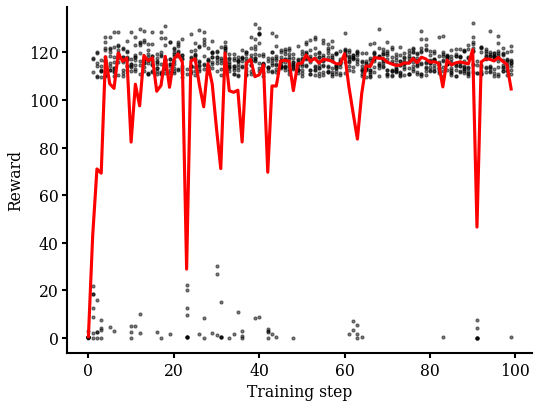

In [32]:
fig, ax = niceFig("Training step", "Reward")
means = []
for i, eps in enumerate(eval_episodes):
    rewards = [ep["reward"].sum() for ep in eps]
    means.append([i, np.mean(rewards)])
    ax.plot(np.ones(len(rewards))*i, rewards, "k.", alpha=0.5)
means = np.array(means)
ax.plot(means[:, 0], means[:, 1], "r-", lw=3)
plt.savefig(os.path.join(figDir, "DDR_trainingHistory.png"), dpi=200, bbox_inches="tight")

## Evaluate

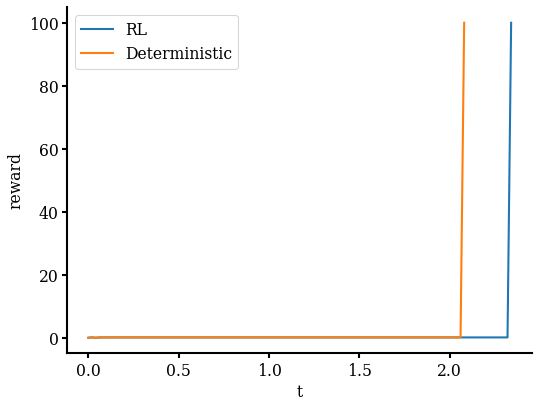

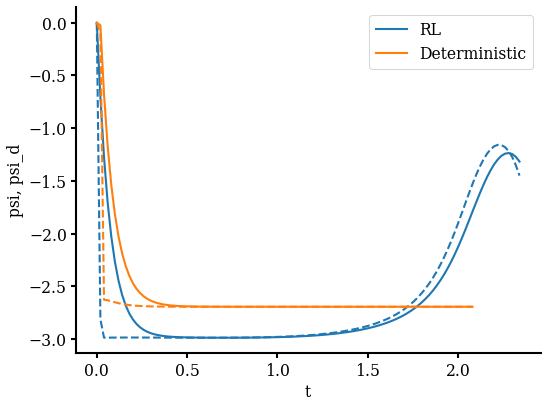

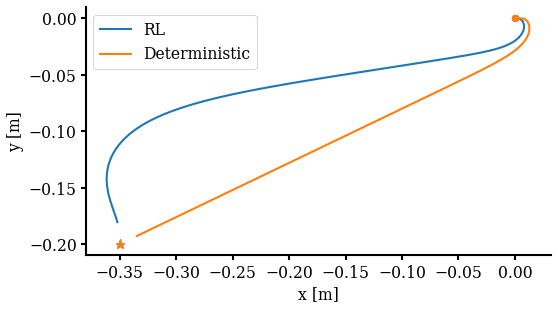

In [31]:
episodeData = {
    "RL": evaluationEpisode(env_eval, agent, seed=123, fixedConditions=True),
    "Deterministic": evaluationEpisode(env_eval, DummyDdrAgent(), seed=123, fixedConditions=True),
}

fig, ax = niceFig("t", "reward")
for variant in episodeData:
    ax.plot(episodeData[variant]["t"], episodeData[variant]["reward"], "-", lw=2, label=variant)
ax.legend()

fig, ax = niceFig("t", "psi, psi_d")
for variant in episodeData:
    ln = ax.plot(episodeData[variant]["t"], episodeData[variant]["psi"], "-", lw=2, label=variant)[0]
    ax.plot(episodeData[variant]["t"], episodeData[variant]["psi_d"], "--", lw=2, c=ln.get_color())
ax.legend()

fig, ax = niceFig("x [m]", "y [m]")
ax.set_aspect("equal")
for variant in episodeData:
    ln = ax.plot(episodeData[variant]["x"], episodeData[variant]["y"], "-", lw=2, label=variant)[0]
    ax.plot(episodeData[variant].loc[0, "x"], episodeData[variant].loc[0, "y"], "o", c=ln.get_color())
    ax.plot(env_eval.unwrapped.x_g[0], env_eval.unwrapped.x_g[1], "*", c=ln.get_color(), ms=9)
ax.legend()
plt.savefig(os.path.join(figDir, "DDR_trajectory.png"), dpi=200, bbox_inches="tight")